In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from netCDF4 import Dataset
import utils as utl

In [2]:
Nh = 96
Nt = 37
sspacing = 3
tspacing = 4

HTLS_sknots = np.arange(0,Nh,sspacing)
HTHS_sknots = np.arange(0,Nh,1)
LTHS_tknots = np.arange(0,Nh,tspacing)
Nl = len(HTLS_sknots)
Ns = len(LTHS_tknots)

N = Nt*Ns

[]

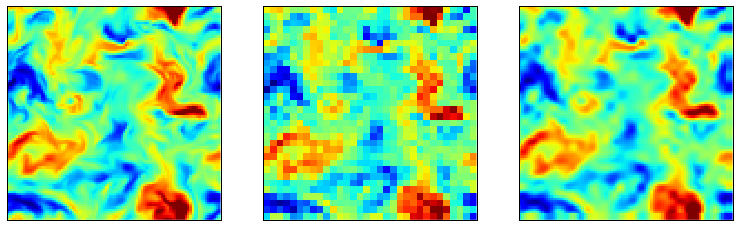

In [3]:
ncfile1 = Dataset('/data/ISOTROPIC/data/data_downsampled4.nc','r')
x_HR_ref = np.array(ncfile1.variables['velocity_x'][0,0:Nh,0:Nh,0])
ncfile1.close()
x_LR = x_HR_ref[0:-1:sspacing,0:-1:sspacing]
x_interp = utl.interp2(HTLS_sknots, HTLS_sknots, x_LR, HTHS_sknots, HTHS_sknots)

fig = plt.figure(figsize=(13, 5))

ax = plt.subplot(1,3, 1)
cax = plt.imshow(x_HR_ref, interpolation='none',clim=[-3,3],cmap='jet')
ax.set_xticks(())
ax.set_yticks(())
    
ax = plt.subplot(1,3, 2)
cax = plt.imshow(x_LR, interpolation='none',clim=[-3,3],cmap='jet')
ax.set_xticks(())
ax.set_yticks(())

ax = plt.subplot(1,3, 3)
cax = plt.imshow(x_interp, interpolation='none',clim=[-3,3],cmap='jet')
ax.set_xticks(())
ax.set_yticks(())

In [4]:
Np = 3 # haft number of predictor
offset = np.arange(-Np*sspacing,(Np+1)*sspacing+1,sspacing)
patchsize_o = len(offset) 
zz_o, yy_o, zz_i, yy_i = utl.gen_grids(sspacing, sspacing, Nh, Np) 

Do = (sspacing+1)*(sspacing+1) # dimension of the HR vector to reconstruct
Di = patchsize_o*patchsize_o # number of LR predictors


Xo_tr = np.zeros((Nt*Ns*Nl*Nl, Do))
Xi_tr = np.zeros((Nt*Ns*Nl*Nl, Di))
ncfile1 = Dataset('/data/ISOTROPIC/data/data_downsampled4.nc','r')

for t in range(Nt):
    count = 0
    for i in LTHS_tknots:
        xh = np.array(ncfile1.variables['velocity_x'][t,0:Nh,0:Nh,i])
        patches_o = xh[yy_o,zz_o]
        patches_i = xh[yy_i, zz_i]
        Xo_tr[(t*Ns+ count)*Nl*Nl:(t*Ns+ count + 1)*Nl*Nl,:] = np.reshape(patches_o,(Nl*Nl, Do))
        Xi_tr[(t*Ns+ count)*Nl*Nl:(t*Ns+ count + 1)*Nl*Nl,:] = np.reshape(patches_i,(Nl*Nl, Di)) 
        # reshape will take from last index toward first one
        count = count + 1
ncfile1.close()

# normalized: centered, variance 1
mea_i = np.zeros(Di)
sig_i = np.zeros(Di)
for k in range(Di):
    mea_i[k] = np.mean(Xi_tr[:,k])
    sig_i[k] = np.std(Xi_tr[:,k])
    Xi_tr[:,k] = (Xi_tr[:,k]-mea_i[k])/sig_i[k]
    
mea_o = np.zeros(Do)
sig_o = np.zeros(Do)
for k in range(Do):
    mea_o[k] = np.mean(Xo_tr[:,k])
    sig_o[k] = np.std(Xo_tr[:,k])
    Xo_tr[:,k] = (Xo_tr[:,k]-mea_o[k])/sig_o[k]    
    
print "Xo_tr is of size:", np.shape(Xo_tr)
print "Xi_tr is of size:", np.shape(Xi_tr)

Xo_tr is of size: (909312, 16)
Xi_tr is of size: (909312, 64)


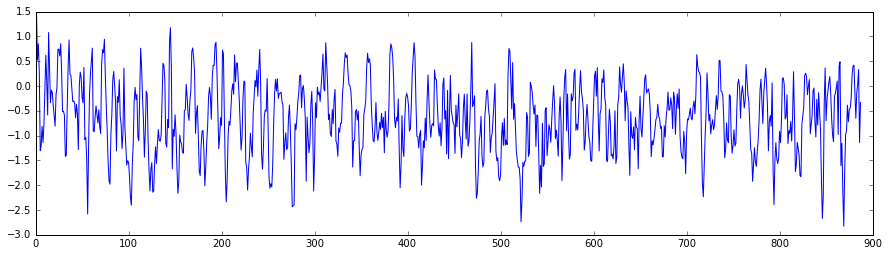

In [5]:
fig = plt.figure(figsize=(15, 4))
ax=plt.plot(Xo_tr[1:-1:Nl*Nl,1])

In [6]:
Ntr = 5000
ids = np.random.permutation(np.shape(Xo_tr)[0])[0:Ntr]

from sklearn.grid_search import GridSearchCV
from sklearn.kernel_ridge import KernelRidge

kr = GridSearchCV(KernelRidge(kernel='rbf'), cv = 10,
                  param_grid={"alpha": np.logspace(-5, 0, 6), "gamma": np.logspace(-10, 0, 5)})
kr.fit(Xi_tr[ids,:], Xo_tr[ids,:])

print kr.best_estimator_

KernelRidge(alpha=0.0001, coef0=1, degree=3, gamma=1.0000000000000001e-05,
      kernel='rbf', kernel_params=None)


In [8]:
from sklearn.learning_curve import learning_curve
from sklearn.learning_curve import validation_curve
param_range=np.logspace(-10, 0, 11)
train_scores, test_scores = validation_curve(KernelRidge(kernel='rbf', alpha=kr.best_estimator_.alpha), 
                                             Xi_tr[0:Ntr,:], Xo_tr[0:Ntr,:], 
                                             param_name="gamma", param_range=param_range, cv=10)

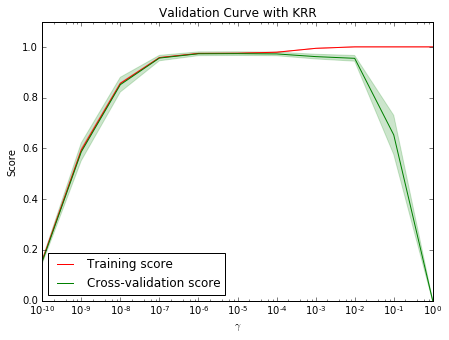

In [9]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(7, 5))
plt.title("Validation Curve with KRR")
plt.xlabel("$\gamma$")
plt.ylabel("Score")
plt.ylim(0, 1.1)
plt.semilogx(param_range, train_scores_mean, label="Training score", color="r")
plt.fill_between(param_range, train_scores_mean - train_scores_std, 
                 train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score", color="g")
plt.fill_between(param_range, test_scores_mean - test_scores_std, 
                 test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()